# CNN

In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch import nn
from torchsummary import summary
import matplotlib.pyplot as plt

## 1 Basic

### 1.1 BatchNorm
BatchNorm的介绍具体参考[动手深度学习](https://zh.d2l.ai/chapter_convolutional-neural-networks/batch-norm.html)。对于FC层输出在每个通道上进行BS(batch size)级别的归一化；对于Conv层输出在每个通道上$H \times W \times B$级别的归一化。

BatchNorm虽然好用，但是也有一些问题（详见[Devils in BatchNorm](https://www.techbeat.net/talks/MTU5NzEyNzg2MjU2MC0yOTktNzUzMjI=)），例如不一致性（inconsistency）问题：
1. 使用了[指数移动平均](https://zhuanlan.zhihu.com/p/68748778)会让学习的参数更加适应最新训练批次的样本
2. 训练集得到的batchnorm参数不一定适合测试集

第1个不一致性问题可以使用Precise BatchNorm，例如暂停更新网络参数，只更新BatchNorm层的参数。

### 1.2 IoU
Intersection over union就是交并比，公式如下：
$$I o U=\frac{|A \cap B|}{|A \cup B|}$$

In [2]:
def compute_iou(rec1, rec2):
    """
    computing IoU
    :param rec1: (y0, x0, y1, x1), which reflects
            (top, left, bottom, right)
    :param rec2: (y0, x0, y1, x1)
    :return: scala value of IoU
    """
    # computing area of each rectangles
    S_rec1 = (rec1[2] - rec1[0]) * (rec1[3] - rec1[1])
    S_rec2 = (rec2[2] - rec2[0]) * (rec2[3] - rec2[1])

    # computing the sum_area
    sum_area = S_rec1 + S_rec2

    # find the each edge of intersect rectangle
    left_line = max(rec1[1], rec2[1])
    right_line = min(rec1[3], rec2[3])
    top_line = max(rec1[0], rec2[0])
    bottom_line = min(rec1[2], rec2[2])

    # judge if there is an intersect
    if left_line >= right_line or top_line >= bottom_line:
        return 0
    else:
        intersect = (right_line - left_line) * (bottom_line - top_line)
        return (intersect / (sum_area - intersect))*1.0

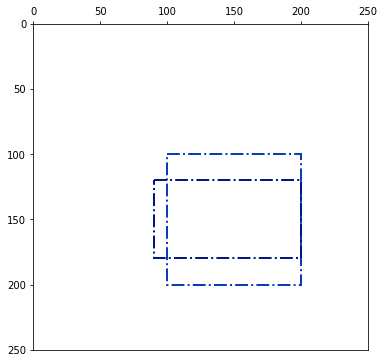

In [3]:
from matplotlib.patches import Rectangle


def plot_init_grid(ax, w=512, h=512):
    ax.xaxis.tick_top()
    ax.set_xlim([0, w])
    ax.set_ylim([0, h])
    ax.invert_yaxis()


def plot_bboxes(bboxes, ax, colors=[]):
    """
    @bboxes: [[y0, x0, y1, x1], ...], which relflects (top, left, bottom, right)
    """
    # 补齐颜色
    dlen = len(bboxes) - len(colors)
    if dlen > 0:
        colors.extend([np.random.rand(3,) for x in range(dlen)])
        
    for (y0, x0, y1, x1), color in zip(bboxes, colors):
        w = x1 - x0
        h = y1 - y0
        xy = (x0, y0)
        rect = Rectangle(xy, w, h, linewidth=2, fill=False, linestyle='-.',
                         edgecolor=color)
        ax.add_patch(rect)


# (top, left, bottom, right)
bbox1 = [100, 100, 200, 200]
bbox2 = [120, 90, 180, 200]

plt.figure(figsize=(6, 6))
ax = plt.gca()
plot_init_grid(ax, 250, 250)
plot_bboxes([bbox1, bbox2], ax)
plt.show()

In [4]:
compute_iou(bbox1, bbox2)

0.5660377358490566

IoU的问题：
如果两个框没有相交，根据定义，IoU=0，不能反映两者的距离大小（重合度）。同时因为loss=0，没有梯度回传，无法进行学习训练。
IoU无法精确的反映两者的重合度大小。如下图所示，三种情况IoU都相等，但看得出来他们的重合度是不一样的，左边的图回归的效果最好，右边的最差。

#### 1.2.1 IoU Loss
训练时，目标检测一般用L2 loss来判断框的好坏，由于L2损失分别优化目标框的4个位置$x_0, y_0, x_1, y_1$，忽略了它们内在的联系，所以会出现某1-2个位置优化的很准，其它不准的情况。UnitBox论文中使用了IoU作为loss，**将这4个变量当成一个整体去优化**，这样还有个好处，IoU的取值范围为$[0, 1]$，相当于归一化了，则不受bbox尺度影响了，**模型可以适应多尺度目标**。另一个问题就是L2 loss无法精确反应预测框的好坏，详见GIoU小节。

![](http://static.zybuluo.com/AustinMxnet/vv4txma59orl7db5sxb89cwi/image.png)

注意UnitBox是针对Densebox论文优化的，Densebox是anchor-free的方法，所以让每个点的向量预测距离上下左右边框的距离$x_t, x_b, x_l, x_r$，但是IoU loss不受影响。但是图中公式加了一个$-ln$，文中解释成输入为IoU的cross-entropy loss，当$p(IoU=1)=1$时，$\mathcal{L}=-pln(IoU)-(1-p)ln(1-IoU)=-ln(IoU)$。这里$p(IoU=1)=1$应该是不对的，个人觉得就是加速神经网络收敛，因为IoU的取值范围为$[0, 1]$，所以越接近0，$-ln(IoU)$越接近于无穷大，如下图所示。

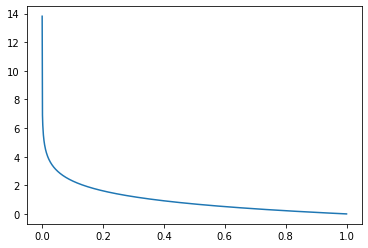

In [5]:
x = np.linspace(0.000001, 1, 1000)
y = -np.log(x)

plt.plot(x, y)
plt.show()

#### 1.2.2 GIoU
**L2 Loss的问题**
1. L2 Loss的另一个问题（其他问题详见IoU Loss小节）是无法精确反应预测框的好坏，训练时候优化L2 Loss并不是完全在优化评价指标IoU，如下图所示gt框为绿色，虽然三个预测黑色框的L2相同，但是明显IoU大的框更好。这也说明，**一个L2局部最优值不一定是IoU的局部最优值**，这说明优化回归损失和IoU值之间仍然存在差距。

![](http://static.zybuluo.com/AustinMxnet/ayzgzo1236wf4kpkfb8ykfk6/image.png)

**IoU Loss的问题**
1. 如果两个框没有相交，**无论距离多远，IoU都为0**，无法反映两者的距离大小（重合度）。同时因为loss=0，**没有梯度回传**，无法进行学习训练。
2. 无法精确的反映两者的重合度大小。如下图所示，三种情况IoU都相等为0.33，但是他们的重合度是不一样的，左边的图回归的效果最好（GIoU=0.33），右边的最差（GIoU=-0.1）。

![](http://static.zybuluo.com/AustinMxnet/d7508h8bbxpd5s8mxqaz9qn5/image.png)

**GIoU公式**

对于两个bounding box A&B，算出其最小凸集（包围A、B的最小包围框）C，然后计算C中除A B外的面积占C总面积的比值，最后用IOU减去这个比值：

$$GIoU = IoU - \frac{C-(A\cup B)}{C}$$

**GIoU特点**

GIoU继承了IoU的一些优点，例如对物体尺寸不敏感，另外还有一些特点：

1. GIOU是IOU的下界，且取值范围为`(-1, 1]`。当两个框不重合时，IoU始终为0，不论A、B相隔多远，但是对于GIOU来说，A，B不重合度越高（离的越远），GIOU越趋近于-1。关于这点，下面再详细解释一下。

2. 当IoU为0时，$GIoU = -1 + \frac{A\cup B}{C}$，两个框没有重合之前，$A \cup B$不变，**最大化GIoU等于最小化C，即两个框要不断靠近**。

In [6]:
def compute_giou(rec1, rec2):
    """
    @param rec1: (y0, x0, y1, x1), which reflects
            (top, left, bottom, right)
    @param rec2: (y0, x0, y1, x1)
    @return: scala value of IoU
    注：图像原点为左上角
    """
    y1, x1, y2, x2 = rec1
    y3, x3, y4, x4 = rec2
    
    area_C = (max(x1, x2, x3, x4) - min(x1, x2, x3, x4)) * \
             (max(y1, y2, y3, y4) - min(y1, y2, y3, y4))
    area_1 = (x2-x1) * (y2-y1)
    area_2 = (x4-x3) * (y4-y3)
    sum_area = area_1 + area_2

    w1 = x2 - x1  # 第一个矩形的宽
    w2 = x4 - x3  # 第二个矩形的宽
    h1 = y2 - y1
    h2 = y4 - y3
    W = min(x1, x2, x3, x4) + w1 + w2 - max(x1, x2, x3, x4)  # 交叉部分的宽
    H = min(y1, y2, y3, y4) + h1 + h2 - max(y1, y2, y3, y4)  # 交叉部分的高
    
    inter_area = W*H
    union_area = sum_area - inter_area
    if W < 0 or H < 0:
        iou = 0
    else:
        iou = inter_area / union_area
    ratio = (area_C - union_area)/area_C
    giou = iou - ratio
    return giou, iou

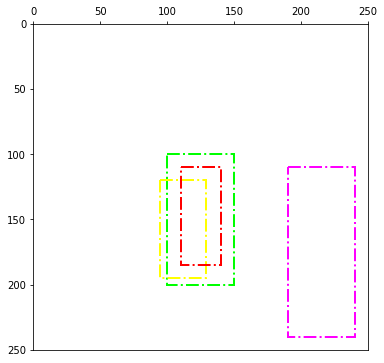

In [7]:
# (top, left, bottom, right)
bbox1 = [100, 100, 200, 150]
bbox2 = [120, 95, 195, 129]
bbox3 = [110, 110, 185, 140]
bbox4 = [110, 190, 240, 240]
color1 = [0, 1, 0] # green
color2 = [1, 1, 0] # yellow
color3 = [1, 0, 0] # red
color4 = [1, 0, 1] # purple


plt.figure(figsize=(6, 6))
ax = plt.gca()
plot_init_grid(ax, 250, 250)
plot_bboxes([bbox1, bbox2, bbox3, bbox4], ax, [color1, color2, color3, color4])
plt.show()

假设绿色的框为gt框，其他为预测框，从图中看出红色的框最好，紫色的最差（没有相交，IoU应该=0），我们分别看下GIoU和IoU是多少：

In [8]:
print("yellow, GIoU:%.4f, IoU:%.4f"%(compute_giou(bbox1, bbox2)))
print("   red, GIoU:%.4f, IoU:%.4f"%(compute_giou(bbox1, bbox3)))
print("purple, GIoU:%.4f, IoU:%.4f"%(compute_giou(bbox1, bbox4)))

yellow, GIoU:0.3819, IoU:0.4047
   red, GIoU:0.4500, IoU:0.4500
purple, GIoU:-0.2296, IoU:0.0000


#### 1.2.3 DIoU
[Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression](https://arxiv.org/pdf/1911.08287.pdf)

**GIoU的问题**

虽然GIoU可以缓解目标框和预测框不重叠情况下的梯度消失问题，但是两者是包含关系时就又退化为IoU Loss了，例如下图所示，目标框为绿色，三个预测框的GIoU和IoU完全相同：

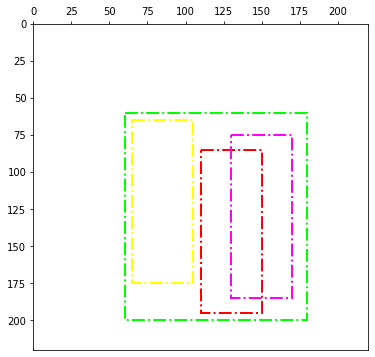

yellow, GIoU:0.2619, IoU:0.2619
   red, GIoU:0.2619, IoU:0.2619
purple, GIoU:0.2619, IoU:0.2619


In [9]:
# (top, left, bottom, right)
w = 40
h = 110
bbox1 = [60, 60, 200, 180]
bbox2 = [65, 65, 65+h, 65+w]
bbox3 = [85, 110, 85+h, 110+w]
bbox4 = [75, 130, 75+h, 130+w]
color1 = [0, 1, 0] # green
color2 = [1, 1, 0] # yellow
color3 = [1, 0, 0] # red
color4 = [1, 0, 1] # purple


plt.figure(figsize=(6, 6))
ax = plt.gca()
plot_init_grid(ax, 220, 220)
plot_bboxes([bbox1, bbox2, bbox3, bbox4], ax, [color1, color2, color3, color4])
plt.show()

print("yellow, GIoU:%.4f, IoU:%.4f"%(compute_giou(bbox1, bbox2)))
print("   red, GIoU:%.4f, IoU:%.4f"%(compute_giou(bbox1, bbox3)))
print("purple, GIoU:%.4f, IoU:%.4f"%(compute_giou(bbox1, bbox4)))

下面通过一个例子来说明GIoU的问题，如下图所示，第一行是GIoU的回归过程（第40、100、400次），绿色框为目标框，黑色为锚框，蓝色为使用GIoU Loss的预测框：

![](http://static.zybuluo.com/AustinMxnet/pszqt70g6kvorrzu3rtgm9fa/image.png)

可以看出GIoU Loss中，蓝色预测框为了与目标框重叠，**开始阶段会逐渐的增大尺寸，到后面重叠阶段，GIoU退化成IoU，因此，它需要在垂直和水平方向需要多次的迭代来达到收敛**。于是DIoU（第二行红色框）的作者提出了两个问题：
- 为了获得更快的收敛速度，是否可以直接最小化预测框和目标框之间的归一化距离？
- 当与目标框有重叠甚至存在包含关系时，如何使得回归速度更准确、更快速？

**Distance-IoU Loss**

边界框回归的好坏需要考虑：
- 重叠面积
- 中心点距离
- 长宽比

无论是IoU还是GIoU都只考虑了第一点重叠面积，DIoU在此基础上考虑了第二点中心点距离：

![](http://static.zybuluo.com/AustinMxnet/963tzvgz7lr4wjkyzf6xbule/image.png)

DIoU在IoU的基础上加入了一个惩罚项，用于度量目标框和预测框之间中心点的距离，在最小化边界框中心点的距离过程中，能够使得边界框收敛速度更快：

$$DIoU = IoU - \frac{\rho^2\left(b, b^{gt}\right)}{c^{2}}$$

式中$b$和$b^{gt}$分别代表两个框，$\rho$代表两点欧式距离（这里就是两个框的中心），$c$代表覆盖两个边界框的最小框的对角线长度(上图中蓝色线)。

对应的DIoU Loss：
$$\mathcal{L}_{DIOU} = 1 - DIoU = 1 - IoU + \frac{\rho^{2}\left(b, b^{g t}\right)}{c^{2}}$$

In [10]:
def compute_diou(rec1, rec2):
    """
    @param rec1: (y0, x0, y1, x1), which reflects
            (top, left, bottom, right)
    @param rec2: (y0, x0, y1, x1)
    @return: scala value of IoU
    注：图像原点为左上角
    """
    y1, x1, y2, x2 = rec1
    y3, x3, y4, x4 = rec2
    
    area_1 = (x2-x1) * (y2-y1)
    area_2 = (x4-x3) * (y4-y3)
    sum_area = area_1 + area_2
    b1w, b2w = x2 - x1, x4 - x3 # 两个框的宽
    b1h, b2h = y2 - y1, y4 - y3 # 两个框的高
    bcx1, bcx2 = min(x1, x3), max(x2, x4) # 包含两个框的最小矩形的左上和右下顶点x坐标
    bcy1, bcy2 = min(y1, y3), max(y2, y4) # 包含两个框的最小矩形的左上和右下顶点y坐标
    
    W = bcx1 + b1w + b2w - bcx2  # 两个框交叉部分的宽
    H = bcy1 + b1h + b2h - bcy2  # 两个框交叉部分的高
    inter_area = W*H
    union_area = sum_area - inter_area
    if W < 0 or H < 0:
        iou = 0
    else:
        iou = inter_area / union_area
        
    center_b1x, center_b1y = (x1+x2)/2, (y1+y2)/2
    center_b2x, center_b2y = (x3+x4)/2, (y3+y4)/2
    d2 = (center_b1x-center_b2x)**2 + (center_b2y-center_b1y)**2
    
    # (right-left)**2 + (bottom-top)**2
    c2 = (bcx2 - bcx1)**2 + (bcy2 - bcy1)**2
        
    ratio = d2 / c2
    diou = iou - ratio
    return diou, iou

下面我们看下在GIoU章节里那三个被包含在目标框中的预测框有没有得到优化：

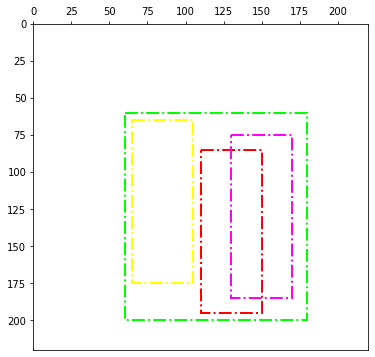

yellow, DIoU:0.2229, GIoU:0.2619, IoU:0.2619
   red, DIoU:0.2560, GIoU:0.2619, IoU:0.2619
purple, DIoU:0.2354, GIoU:0.2619, IoU:0.2619


In [11]:
w = 40
h = 110
# (top, left, bottom, right)
bbox1 = [60, 60, 200, 180]
bbox2 = [65, 65, 65+h, 65+w]
bbox3 = [85, 110, 85+h, 110+w]
bbox4 = [75, 130, 75+h, 130+w]
color1 = [0, 1, 0] # green
color2 = [1, 1, 0] # yellow
color3 = [1, 0, 0] # red
color4 = [1, 0, 1] # purple


plt.figure(figsize=(6, 6))
ax = plt.gca()
plot_init_grid(ax, 220, 220)
plot_bboxes([bbox1, bbox2, bbox3, bbox4], ax, [color1, color2, color3, color4])
plt.show()

print("yellow, DIoU:%.4f, GIoU:%.4f, IoU:%.4f"%(compute_diou(bbox1, bbox2)[0], *compute_giou(bbox1, bbox2)))
print("   red, DIoU:%.4f, GIoU:%.4f, IoU:%.4f"%(compute_diou(bbox1, bbox3)[0], *compute_giou(bbox1, bbox3)))
print("purple, DIoU:%.4f, GIoU:%.4f, IoU:%.4f"%(compute_diou(bbox1, bbox4)[0], *compute_giou(bbox1, bbox4)))

可以看出最接近中心的红色框DIoU分数最高，最偏离中心的黄色框DIoU分数最低。DIoU解决了目标框回归三大问题（重叠面积，中心点距离，长宽比）的“中心点距离”，可以直接最小化预测框和目标框之间的归一化距离。

**DIoU与NMS**
NMS（Non-Maximum Suppression，非极大值抑制）唯一考虑的因素就是重叠面积，这样显然是不合理的，如果存在遮挡的情况，这样就会产生错误的抑制。本文提出将DIoU应用于NMS中，这样不仅考虑重叠区域，还会将检测框与目标框中心点之间的距离考虑在内，这样能够有效避免上述错误。

$$
s_{i}=\left\{\begin{array}{l}
s_{i}, \quad I o U-\mathcal{R}_{D I o U}\left(\mathcal{M}, B_{i}\right)<\varepsilon \\
0, \quad I o U-\mathcal{R}_{D I o U}\left(\mathcal{M}, B_{i}\right) \geq \varepsilon
\end{array}\right.
$$

$s_i$是分类分数，$\varepsilon$是NMS threshold。

从下图可以看出，使用了DIou-NMS可以避免重叠的目标被过滤掉：

![](http://static.zybuluo.com/AustinMxnet/dplq4xvg74b6upcjx4jynev8/image.png)

#### 1.2.4 CIoU
CIoU和DIoU在同一篇论文中提出来的，作者在这篇文章（[Enhancing Geometric Factors in Model Learning and Inference for Object Detection and Instance Segmentation](https://arxiv.org/pdf/2005.03572.pdf)）里详细介绍了实现方法。**针对DIoU遗留了“长宽比”的问题**，CIoU在DIoU的基础上增加了长宽比的惩罚项：

$$DIoU = IoU - \frac{\rho^2\left(b, b^{gt}\right)}{c^{2}} - \alpha v$$

其中$\alpha$是用来平衡比例的系数，$v$是用来衡量预测框和目标框之间的比例一致性：

$$
v=\frac{4}{\pi}\left(\arctan \left(\frac{w^{gt}}{h^{gt}}\right)-\arctan \left(\frac{w}{h}\right)\right)^{2}
$$

$$
\alpha=\frac{v}{(1-I o U)+v}
$$

这里使用了[mmdetection](https://mmdetection.readthedocs.io/en/latest/_modules/mmdet/models/losses/iou_loss.html)里的代码，和上述公式一致，但是作者的代码稍微有些区别（见后文）。

In [12]:
import math

def compute_ciou(pred, target, eps=1e-7):
    """
    @pred (Tensor): Predicted bboxes of format (x1, y1, x2, y2), shape (n, 4).
    @target (Tensor): Corresponding gt bboxes, shape (n, 4).
    @eps (float): Eps to avoid log(0).
    Return:
        Tensor: Loss tensor.
    """
    # overlap
    lt = torch.max(pred[:, :2], target[:, :2])
    rb = torch.min(pred[:, 2:], target[:, 2:])
    wh = (rb - lt).clamp(min=0)
    overlap = wh[:, 0] * wh[:, 1]

    # union
    ap = (pred[:, 2] - pred[:, 0]) * (pred[:, 3] - pred[:, 1])
    ag = (target[:, 2] - target[:, 0]) * (target[:, 3] - target[:, 1])
    union = ap + ag - overlap + eps

    # IoU
    ious = overlap / union

    # enclose area
    enclose_x1y1 = torch.min(pred[:, :2], target[:, :2])
    enclose_x2y2 = torch.max(pred[:, 2:], target[:, 2:])
    enclose_wh = (enclose_x2y2 - enclose_x1y1).clamp(min=0)

    cw = enclose_wh[:, 0]
    ch = enclose_wh[:, 1]

    c2 = cw**2 + ch**2 + eps

    b1_x1, b1_y1 = pred[:, 0], pred[:, 1]
    b1_x2, b1_y2 = pred[:, 2], pred[:, 3]
    b2_x1, b2_y1 = target[:, 0], target[:, 1]
    b2_x2, b2_y2 = target[:, 2], target[:, 3]

    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

    left = ((b2_x1 + b2_x2) - (b1_x1 + b1_x2))**2 / 4
    right = ((b2_y1 + b2_y2) - (b1_y1 + b1_y2))**2 / 4
    rho2 = left + right

    factor = 4 / math.pi**2
    v = factor * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)

    # CIoU
    cious = ious - (rho2 / c2 + v**2 / (1 - ious + v))
    return cious

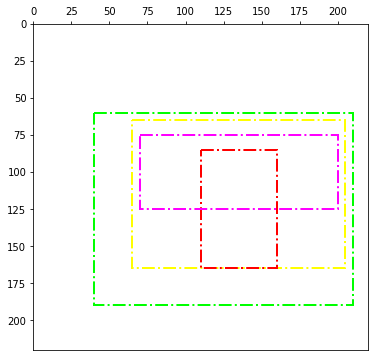

yellow, DIoU:0.6291, GIoU:0.6335, IoU:0.6335
   red, DIoU:0.1788, GIoU:0.1810, IoU:0.1810
purple, DIoU:0.2783, GIoU:0.2941, IoU:0.2941


In [13]:
w, h = 150, 130

# (top, left, bottom, right)
bbox1 = [60, 40,  60+h,    60+w]
bbox2 = [65, 65,  65+h-30, 65+w-10]
bbox3 = [85, 110, 85+h-50, 110+w-100]
bbox4 = [75, 70, 75+h-80, 130+w-80]
color1 = [0, 1, 0] # green
color2 = [1, 1, 0] # yellow
color3 = [1, 0, 0] # red
color4 = [1, 0, 1] # purple


plt.figure(figsize=(6, 6))
ax = plt.gca()
plot_init_grid(ax, 220, 220)
plot_bboxes([bbox1, bbox2, bbox3, bbox4], ax, [color1, color2, color3, color4])
plt.show()

print("yellow, DIoU:%.4f, GIoU:%.4f, IoU:%.4f"%(compute_diou(bbox1, bbox2)[0], *compute_giou(bbox1, bbox2)))
print("   red, DIoU:%.4f, GIoU:%.4f, IoU:%.4f"%(compute_diou(bbox1, bbox3)[0], *compute_giou(bbox1, bbox3)))
print("purple, DIoU:%.4f, GIoU:%.4f, IoU:%.4f"%(compute_diou(bbox1, bbox4)[0], *compute_giou(bbox1, bbox4)))

In [14]:
# (left, top, right, bottom)
bbox1[0], bbox1[1], bbox1[2], bbox1[3] = bbox1[1], bbox1[0], bbox1[3], bbox1[2]
bbox2[0], bbox2[1], bbox2[2], bbox2[3] = bbox2[1], bbox2[0], bbox2[3], bbox2[2]
bbox3[0], bbox3[1], bbox3[2], bbox3[3] = bbox3[1], bbox3[0], bbox3[3], bbox3[2]
bbox4[0], bbox4[1], bbox4[2], bbox4[3] = bbox4[1], bbox4[0], bbox4[3], bbox4[2]

bboxes1 = torch.tensor([bbox1, bbox1, bbox1], dtype=torch.float32)
bboxes2 = torch.tensor([bbox2, bbox3, bbox4], dtype=torch.float32)
compute_ciou(bboxes1, bboxes2)

tensor([0.6291, 0.1757, 0.2768])

可以看出，DIoU和CIoU的差别不大。相比黄色框，紫色和红色的比例不是很好，所以CIoU的分数更低一些。

另外作者的论文/代码对上述公式有些改变：

1. 作者在论文中对$\alpha$还做了分段函数，理由是当$IoU<0.5$说明两个框并没有很好的匹配上，重点应该先优化两者的重叠度，此时退化成DIoU；而当$IoU \gt 0.5$时，需要重点优化比例。这与DIoU小节提到的motivation一致，即“当与目标框有重叠甚至存在包含关系时，如何使得回归速度更准确、更快速”：

$$
\alpha=\left\{\begin{array}{ll}
0, & \text { if } I o U<0.5 \\
\frac{V}{(1-I o U)+V}, & \text { if } I o U \geq 0.5
\end{array}\right.
$$

2. 根据$v=\frac{4}{\pi}\left(\arctan \left(\frac{w^{gt}}{h^{gt}}\right)-\arctan \left(\frac{w}{h}\right)\right)^{2}$，可以求得：

$$
\frac{\partial v}{\partial w}=\frac{8}{\pi^{2}}\left(\arctan \frac{w^{g t}}{h^{g t}}-\arctan \frac{w}{h}\right) \times \frac{h}{w^{2}+h^{2}}
$$

$$
\frac{\partial v}{\partial h}=-\frac{8}{\pi^{2}}\left(\arctan \frac{w^{g t}}{h^{g t}}-\arctan \frac{w}{h}\right) \times \frac{w}{w^{2}+h^{2}}
$$

作者认为分母$w^2+h^2$很小（[作者将$w, h$归一化](https://github.com/Zzh-tju/DIoU-SSD-pytorch/issues/4)为`[0, 1]`），会产生梯度爆炸，所以直接去除了，详见但是作者提供的代码没有找到相关内容，只有一个[issue](https://github.com/Zzh-tju/DIoU-pytorch-detectron/issues/3)回复将$w$和$h$设为`no_grad`：

In [15]:
%%script true

...
u = d / c
v = torch.atan(w_gt / h_gt) - torch.atan(w_pred / h_pred)
with torch.no_grad():
    w_pred1 = w_pred * v
    h_pred1 = h_pred * v
ciou_loss =(1-iou+u+8/(math.pi**2) * (w_pred1*h_pred- h_pred1*w_pred)).sum()

3. 在这个[issue](https://github.com/Zzh-tju/DIoU-SSD-pytorch/issues/4)中，作者说$\alpha$也不参与梯度计算，没有给出任何理由，代码如下：

In [16]:
%%script true

with torch.no_grad():
    alpha = v / (1 - iou + v)

**Cluster-NMS**

这篇文章除了介绍CIoU，另一个贡献是Cluster-NMS，有一些有趣的数学推导，目的是加速NMS，详见[一文打尽目标检测NMS——效率提升篇](https://zhuanlan.zhihu.com/p/157900024)，而且还可以避免过滤重叠物体：

![](http://static.zybuluo.com/AustinMxnet/yjtmihgi7c9l3b1xfygp4ri2/image.png)

## 2 Paper

### 2.1 SENet
- 参考：[[论文笔记]-SENet和SKNet(附代码)](https://zhuanlan.zhihu.com/p/76033612)
- Pytorch代码：https://github.com/moskomule/senet.pytorch


![](http://static.zybuluo.com/AustinMxnet/6sfp5yrczet76xl5qitd9cv4/image.png)

一共有三步，分别是Squeeze，Excitation和Fscale。代码中的`r`是一个缩放参数，默认16，文中说引入这个参数是为了减少`channel`个数从而降低计算量。

In [17]:
class SEBlock(nn.Module):
    def __init__(self, channel, r=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel//r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c , _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Fscale
        y = torch.mul(x, y)
        return y

In [18]:
x = torch.rand(1, 128, 28, 28)
out = SEBlock(128)(x)

out.shape

torch.Size([1, 128, 28, 28])

可以看到`SEBlock`并没有改变`x.shape`，只是给每个通道根据计算的权重重新赋值。

`SEBlock`很容易集成到现有的模块中，例如对ResNet来说只需要对`Residual`加一步`SEBlock`即可：

![](http://static.zybuluo.com/AustinMxnet/jk0x9zla6pe93few53nz7vow/image.png)

集成的SE-ResNet可以参考[github](https://github.com/moskomule/senet.pytorch/blob/master/senet/se_resnet.py#L11)，部分代码如下所示。注意这个仓库中命名的是`SELayer`而不是`SEBlock`。

In [19]:
%%script true
from torchvision.models import ResNet


def se_resnet34(num_classes=1_000):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBasicBlock, [3, 4, 6, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


def se_resnet50(num_classes=1_000, pretrained=False):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBottleneck, [3, 4, 6, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    if pretrained:
        model.load_state_dict(load_state_dict_from_url(
            "https://github.com/moskomule/senet.pytorch/releases/download/archive/seresnet50-60a8950a85b2b.pkl"))
    return model

### 2.2 SKNet
- 参考：[[论文笔记]-SENet和SKNet(附代码)](https://zhuanlan.zhihu.com/p/76033612)

SKNet的核心就是Selective Kernel Convolution，如下图所示：

![](http://static.zybuluo.com/AustinMxnet/j8m6bvndtwx4zgq6m9sy73tm/image.png)

Selective Kernel Convolution主要有三步：
1. **Split**：用了两组不同大小的Kernel对$X$分别做卷积运算，得到两个相同shape的输出$\widetilde{\mathbf{U}}$和$\widehat{\mathbf{U}}$。

2. **Fuse**：将$\widetilde{\mathbf{U}}$和$\widehat{\mathbf{U}}$相加得到$\mathbf{U}$，然后类似SENet对$\mathbf{U}$计算通道之间的权重$a,b$。但是不同于SENet计算一组通道之间的权重，即一次softmax运算；而SKNet计算每个通道在两个分支上的权重，共channel次softmax运算，也就是$a,b$每个相同位置上的值加起来为1。

3. **Select**：根据计算$a,b$对$\widetilde{\mathbf{U}}$和$\widehat{\mathbf{U}}$做加权求和，得到$\mathbf{V}$。

下面的代码实现了Selective Kernel Convolution。注意几点：
1. `M`对应分支数
2. `reduction`对应SENet中的r，是一个缩放参数，目的减少channel个数从而降低计算量
3. 论文中说可以用dilated的`conv3x3`代替`conv5x5`，对应代码`dilation=1+i`
4. `forward`中的`feats`对应$\mathbf{U}$，shape和`x`相同

In [20]:
class SKConv(nn.Module):
    def __init__(self, channels, stride=1, M=2, reduction=4):
        super().__init__()
        self.conv1 = nn.ModuleList([])
        for i in range(M):
            self.conv1.append(nn.Sequential(
                nn.Conv2d(channels, channels, 3, stride,
                          padding=1+i, dilation=1+i, bias=False),
                nn.BatchNorm2d(channels),
                nn.ReLU()
            ))
        self.att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels//reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channels//reduction, channels * M, 1)
        )

    def forward(self, x):
        splited = [conv(x) for conv in self.conv1]
        feats = sum(splited)  
        att = self.att(feats) # shape = (batch num, (channels*M), 1, 1)
        # shape = (batch num, M, channels)
        att = att.view(x.size(0), len(self.conv1), x.size(1)) 
        att = F.softmax(att, dim=1)
        att = att.view(x.size(0), -1, 1, 1)
        att = torch.split(att, x.size(1), dim=1)

        return sum([a * s for a, s in zip(att, splited)])

测试一下$14\times 14$块（见下面第二个图）中的`SKConv`。注意如果不是块中第一次卷积运算（即输入不是$28\times 28$的输出），是不需要改变feature maps的大小，使用默认`stride=1`。

In [21]:
x = torch.rand(2, 1024, 14, 14)
skconv = SKConv(1024)
out = skconv(x)
print('out shape : {}'.format(out.shape))

# 测试backward()和loss
criterion = nn.L1Loss()
loss = criterion(out, x)
loss.backward()
print('loss value : {}'.format(loss))

out shape : torch.Size([2, 1024, 14, 14])
loss value : 0.41586658358573914


有了`SKConv`，我们就可以构建基于SKNet的ResNet了，例如SKNet-50，只需要替换ResNet模块中的$3\times 3$卷积。ResNet模块如下图所示，左边是普通的ResNet模块，右边是bottlenecck结构的ResNet模块：

![](http://static.zybuluo.com/AustinMxnet/geba8sxfed73kwumnyrdwiy7/image.png)

完整的SKNet结构如下图所示。在max pool之后，每个block会重复一定的次数（3，4，6，3），这些block第一次时候都需要将feature maps减半，此时输入的通道数是输出的一半。例如$56\times 56$中最后一次输出的通道数为256，即$28\times 28$的输入，而$28\times 28$的输出为512。

![](http://static.zybuluo.com/AustinMxnet/f7cgwxi5o8xmvyry1oysr56h/image.png)

代码中使用了`in_channels == out_channels`来判断是否需要对feature maps的大小减半：

In [22]:
from torch.nn.quantized import FloatFunctional


class SKUnit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        if in_channels == out_channels:
            mid_channels = in_channels // 2
            stride = 1
            self.shortcut = nn.Sequential()
        else:
            mid_channels = in_channels
            stride = 2
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels))
            
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            SKConv(mid_channels, stride),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.relu = FloatFunctional()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        x = self.shortcut(x)
        return self.relu.add_relu(x, out)

测试不需要减半的`SKUnit`：

In [23]:
x = torch.rand(8, 64, 32, 32)
out = SKUnit(64, 64)(x)

out.shape

torch.Size([8, 64, 32, 32])

测试需要减半的SKUnit：

In [24]:
out = SKUnit(64, 128)(x)

out.shape

torch.Size([8, 128, 16, 16])

### 2.3 ResNeXt
- [ResNeXt的分类效果为什么比Resnet好?](https://www.zhihu.com/question/323424817)
- [薰风读论文：ResNeXt 深入解读与模型实现](https://zhuanlan.zhihu.com/p/78019001)

神经网络有两个重要的参数，深度和宽度（这里指的是通道数：the number of channels in a layer），经过ResNet等文章改进后，这两个参数对目前的网络的提升效果不是很明显了，大家开始对各种超参下手，这样很容易导致某一数据集碰巧适合一个“乱调”的超参，使网络丧失了泛化性。本文提出了一个新的参数cardinality，如下图右边网络中的“total 32 paths”，本质上就是对图中左边的3x3 conv做分组卷积：

![](http://static.zybuluo.com/AustinMxnet/4i1l4zpoi5h4f197on71hcs2/image.png)

![](http://static.zybuluo.com/AustinMxnet/g0ttoq6klzia3adzxtz81prs/image.png)

作者这么做的原因是受到Inception结构和AlexNet分组卷积启发，认为**split-transform-merge结构能达到大型密集网络的表达能力**，而计算量却要小很多。

> [ResNeXt的分类效果为什么比Resnet好?](https://www.zhihu.com/question/323424817/answer/1078704765) 一个答案认为多个cardinality和NLP中的multi-head attention是一个思路。每组是不同的subspace，就能学到更diverse的表示。

![](http://static.zybuluo.com/AustinMxnet/b5cahsk10t89licwxt5s8ek1/image.png)

接着为了简化计算，作者证明了上图中3个block是等价的，于是**输入和输出就简化成了一次1x1的卷积**，而不是原来cardinality（上图中为32）次。对比原来的ResNet结构（第一张图左），ResNeXt中的通道总数反而增多了（从64变成了128），这样其实也是增加了模型的能力，**但是重点是几乎没有增加任何的计算量和参数量！！！，原理类似Depthwise Conv**，计算量和参数量参见下图最后一行。

代码很简单，只需要对ResNet的代码微调：一是输入的通道数；二是将中间的conv3x3变成分组卷积，只要传入`groups=cardinality`参数即可：

In [25]:
class Block(nn.Module):
    '''Grouped convolution block.'''
    expansion = 2

    def __init__(self, in_channels, gw, cardinality=32, stride=1):
        """
        @gw, group width
        """
        super().__init__()
        
        out_channels = gw * self.expansion
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, gw, kernel_size=1, bias=False),
            nn.BatchNorm2d(gw),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(gw, gw, kernel_size=3, stride=stride,
                      padding=1, groups=cardinality, bias=False),
            nn.BatchNorm2d(gw),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(gw, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if (stride != 1) or (in_channels != out_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels))
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

测试下图中conv4第一次之后的输入：

In [26]:
x = torch.rand(2, 1024, 14, 14)
out = Block(1024, 512)(x)

print('out shape : {}'.format(out.shape))

out shape : torch.Size([2, 1024, 14, 14])


测试下图中conv4第一次输入，即conv3的输出：

In [27]:
x = torch.rand(2, 512, 28, 28)
out = Block(512, 512, stride=2)(x)

print('out shape : {}'.format(out.shape))

out shape : torch.Size([2, 1024, 14, 14])


![](http://static.zybuluo.com/AustinMxnet/a8sd9f5m8g0vz762s07iqxco/image.png)

有了基础的`Block`就可以构建完整的`ResNeXt`了，例如上图对比了`ResNet-50`和`ResNeXt-50`。代码类似[ResNet](https://github.com/pytorch/vision/blob/3942b192e33dd79b6d9770149371bd58a483d47b/torchvision/models/resnet.py#L101)，提换为上面的`Block`并新增`cardinality`参数：

In [28]:
class ResNeXt(nn.Module):
    def __init__(self, block, layers, cardinality, num_classes=1000):
        super(ResNeXt, self).__init__()
        self.inplanes = 64
        self.cardinality = cardinality
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 128, layers[0],
                                       in_channels=64)
        self.layer2 = self._make_layer(block, 256,  layers[1])
        self.layer3 = self._make_layer(block, 512,  layers[2])
        self.layer4 = self._make_layer(block, 1024, layers[3])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024 * block.expansion, num_classes)

    def _make_layer(self, block, group_width, num_blocks, in_channels=None):
        layers = []

        if in_channels == None:
            in_channels = group_width
        layers.append(block(in_channels, group_width, self.cardinality, 2))

        inchannels = group_width * block.expansion
        for _ in range(1, num_blocks):
            layers.append(
                block(inchannels, group_width, self.cardinality, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


def ResNeXt50_32x4d():
    return ResNeXt(Block, layers=[3, 4, 6, 3], cardinality=32)

In [29]:
x = torch.rand(2, 3, 224, 224)
out = ResNeXt50_32x4d()(x)

print('out shape : {}'.format(out.shape))
#summary(ResNeXt50_32x4d(), (3, 224, 224))

out shape : torch.Size([2, 1000])


### 2.4 ResNeSt
- 作者视频讲解：[张航-ResNeSt：拆分注意力网络](https://www.bilibili.com/video/BV1PV411k7ch)

虽然论文中给的图比较了SENet和SKNet，但是ResNeSt主要结合了SKNet的分支间通道attention，和ResNeXt多分支的特点。在ResNeSt提出cardinality的基础上，在每个cardinality维度中又新增了radix参数，也就是分支中的分支：

![](http://static.zybuluo.com/AustinMxnet/c4tn4s3wfk9m1f70o871zero/image.png)

首先看下单独cardinality模块的处理，先经过1x1卷积缩小通道，然后经过3x3卷积提取特征，这和标准的ResNet没区别（除了是radix个分支）。下面就是ResNeSt中重点**Split Attention**：

![](http://static.zybuluo.com/AustinMxnet/z6bbl89fjw9k7wpgm068z6nz/image.png)

图中$r$个$h \times w \times c'$的输入经过Global Average Pooling和2个FC层后，得到$r$（radix）个`Dense c`，然后在$c$（channel）维度上做softmax，得到$r \times c$的权重图，权重图的第$i$列对应第$i$个channel的$r$个权重分布，下面的代码省略了GAP和FC：

In [30]:
r = 2
c = 3
x = torch.rand(r, c)
xs = F.softmax(x, dim=0)
xs

tensor([[0.5050, 0.5347, 0.5459],
        [0.4950, 0.4653, 0.4541]])

结果权重`xs`中每一列有$r=2$个权重（每一列和为1）。

**这样虽然能求得cardinality个大分支的输出，但是要计算cardinality次**。在附录中，作者将$\text{radix} \times \text{cardinality}$等价变换为$\text{cardinality} \times \text{radix}$，这样只需计算一次就可以得到$\text{radix} \times \text{cardinality} \times c$的softmax权重图：

In [31]:
r = 2
cardinality = 4
c = 3
x_gap = torch.rand(cardinality, r, c) # after global average pooling
xs = x_gap.transpose(0, 1)
xs = F.softmax(xs, dim=0)
xs

tensor([[[0.3815, 0.3320, 0.5162],
         [0.4403, 0.3633, 0.5125],
         [0.5521, 0.6012, 0.4880],
         [0.5091, 0.5646, 0.5910]],

        [[0.6185, 0.6680, 0.4838],
         [0.5597, 0.6367, 0.4875],
         [0.4479, 0.3988, 0.5120],
         [0.4909, 0.4354, 0.4090]]])

注意虽然输入的shape为$\text{cardinality} \times r \times c$，但是经过`transpose(0, 1)`后就对调了$\text{cardinality}$和$r$。如下图所示（k=cardinality），若将$(h,w,c)$分为$(k, r, h, w, c')$，并按照相同$r$的$k \times (h,w,c')$放在一起，只需要用一个group conv生成：`nn.Conv2d(c, c'*radix, groups=cardinality*radix)`。

> 图中一共有$\text{cardinality}=k$组，每组有$\text{radix}=r$个分支，每个分支通道数为$c'/k$。所以当`Conv2d`的参数`out_channel=c*radix`而`groups=k*radix`时，`Conv2d`每一`group`输出的通道数就是等于$c'/k$！！！

有了权重`xs`后，只需要将`xs`乘上相同shape的`x`再加上`x`就得到了Split-Attention的输出（注意这里省略了1x1缩小和放大通道的步骤）。这里有证明两者等价证明和论文作者测试代码（载入等价的网络权重，提供相同的输入，通过测试输出是否相同来验证模型是否等价），详见[ResNeSt 实现有误？](https://zhuanlan.zhihu.com/p/135220104)。

![](http://static.zybuluo.com/AustinMxnet/8hjis3n8sybi782qv7g2fks1/image.png)

注意图中使用的是**r-Softmax**，当`radix=1`时用`sigmoid`，公式如下：

$$a_{i}^{k}(c)=\left\{\begin{array}{ll}
\frac{\exp \left(\mathcal{G}_{i}^{c}\left(s^{k}\right)\right)}{\sum_{j=0}^{R} \exp \left(\mathcal{G}_{j}^{c}\left(s^{k}\right)\right)} & \text { if } R>1 \\
\frac{1}{1+\exp \left(-\mathcal{G}_{i}^{c}\left(s^{k}\right)\right)} & \text { if } R=1
\end{array}\right.$$

具体实现如下，注意`x.transpose`操作调换了radix和cardinality维度：

In [32]:
class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1)
            x = x.transpose(1, 2)  # batch, radix, cardinality, -1
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x

In [33]:
radix = 2
cardinality = 4
c = 16
x = torch.rand(1, radix*cardinality, c)
out = rSoftMax(radix, cardinality)(x)

print('out shape : {}'.format(out.shape))

out shape : torch.Size([1, 128])


增加了Split-Attention的ResNet模块代码，注意代码中**用1x1的Conv代替了cardinality\*radix个并行FC的预算**：

In [34]:
class SplAtConv2d(nn.Module):
    """Split-Attention Conv2d
    """

    def __init__(self, in_channels, channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1, bias=False,
                 radix=2, reduction_factor=4, **kwargs):
        super(SplAtConv2d, self).__init__()
        inter_channels = max(in_channels*radix//reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels

        self.conv = nn.Conv2d(in_channels, channels*radix, kernel_size, stride,
                              padding, dilation, groups=groups*radix, bias=bias, **kwargs)
        self.bn0 = nn.BatchNorm2d(channels*radix)
        self.relu = nn.ReLU(inplace=True)

        self.fc1 = nn.Conv2d(channels, inter_channels, 1, groups=self.cardinality)
        self.bn1 = nn.BatchNorm2d(inter_channels)
        self.fc2 = nn.Conv2d(inter_channels, channels *
                             radix, 1, groups=self.cardinality)
        self.rsoftmax = rSoftMax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn0(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited)
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

因为代码中对FC输出用了BatchNorm，所以测试时候batch size > 1：

In [35]:
x = torch.rand(2, 64, 56, 56)
out = SplAtConv2d(64, 32)(x)
print('out shape : {}'.format(out.shape))

out shape : torch.Size([2, 32, 56, 56])


#### 2.4.1 Tricks
本篇论文训练时用到了很多tricks。首先ResNet-D：

![](http://static.zybuluo.com/AustinMxnet/scdvz53jz5elyfjsgdwugxco/image.png)
1. ResNet-B将`s=2`下采样（downsampling）从第一个（最下面）1x1移到了3x3卷积中，避免信息丢失（因为`s=2`的1x1会直接跳过像素）。
2. ResNet-C中将ResNet第一层的7x7卷积用3个3x3卷积代替。
3. ResNet-D中解决了ResNet-B中旁路上1x1在`s=2`时信息丢失的问题，先用`AvgPool`进行下采样。

其他还有Label Smoothing，Mixup Training，Auto Augment等。作者实现的[代码](https://github.com/zhanghang1989/ResNeSt)提供了MXNet和PyTorch版本。

## 3 CV Attention

注意力机制可以分为：
- 通道注意力机制：对通道生成掩码mask，进行打分，代表是SENet, Channel Attention Module
- 空间注意力机制：对空间进行掩码的生成，进行打分，代表是Spatial Attention Module
- 混合域注意力机制：同时对通道注意力和空间注意力进行评价打分，代表的有BAM, CBAM

文章：
- 专栏：[机器视觉Attention机制的研究](https://zhuanlan.zhihu.com/cvattention)
  - [Attention算法调研——视觉应用概况](https://zhuanlan.zhihu.com/p/52925608)
  - [Attention算法调研(一)——机器翻译中的Attention](https://zhuanlan.zhihu.com/p/52786464)
  - [Attention算法调研(二)——机器翻译中的Self Attention](https://zhuanlan.zhihu.com/p/52861193)
  - [Attention算法调研(三)——视觉应用中的Hard Attention](https://zhuanlan.zhihu.com/p/52958865)
  - [Attention算法调研(四)——视觉应用中的Soft Attention](https://zhuanlan.zhihu.com/p/53026371)
  - [Attention算法调研(五)——视觉应用中的Self Attention](https://zhuanlan.zhihu.com/p/53155423)

### 3.1 CBAM
为了强调空间和通道这两个维度上的有意义特征，作者依次应用通道和空间注意力模块，分别在通道和空间维度上学习关注什么、在哪里关注。此外，通过了解要强调或抑制的信息也有助于网络内的信息流动。

![](http://static.zybuluo.com/AustinMxnet/z8o0mdlygap9p5mkkgpbkcae/image.png)

主要网络架构也很简单，上图展示了和ResBlock的结合，对Feature Maps依次通过Channel attention和Spatial attention两个module。原文：   Given an intermediate feature map $\mathbf{F} \in \mathbb{R}^{C \times H \times W}$ as input, CBAM sequentially infers a 1D channel attention map $\mathbf{M}_{\mathbf{c}} \in \mathbb{R}^{C \times 1 \times 1}$ and a 2D spatial attention map $\mathbf{M}_{\mathbf{s}} \in \mathbb{R}^{1 \times H \times W}$:

$$\begin{aligned}
\mathbf{F}^{\prime} &=\mathbf{M}_{\mathbf{c}}(\mathbf{F}) \otimes \mathbf{F} \\
\mathbf{F}^{\prime \prime} &=\mathbf{M}_{\mathbf{s}}\left(\mathbf{F}^{\prime}\right) \otimes \mathbf{F}^{\prime}
\end{aligned}$$

其中$\otimes$表示element-wise multiplication。两个模块详细的结构如下图所示：

![](http://static.zybuluo.com/AustinMxnet/gkkkb0jf3q352fr8mdwgjgda/image.png)

至于为什么Channel在前，Spatial在后，是因为实验结果更好。下面分别看下两个模块。

**Channel attention module**的公式如下：

$$\begin{aligned}
\mathbf{M}_{\mathbf{c}}(\mathbf{F}) &=\sigma(\textit{MLP}(\textit{AvgPool}(\mathbf{F}))+\textit{MLP}(\textit{MaxPool}(\mathbf{F}))) \\
&=\sigma\left(\mathbf{W}_{1}\left(\mathbf{W}_{\mathbf{0}}\left(\mathbf{F}_{\text{avg}}^{\mathbf{c}}\right)\right)+\mathbf{W}_{\mathbf{1}}\left(\mathbf{W}_{\mathbf{0}}\left(\mathbf{F}_{\text{max}}^{\mathbf{c}}\right)\right)\right)
\end{aligned}$$

其中：
- $\mathbf{F}_{\text{avg}}^{\mathbf{c}}$和$\mathbf{F}_{\text{max}}^{\mathbf{c}}$分别表示在空间$HW$维度上average-pooled和max-pooled features，大小为通道数$c$。作者认为结合max-pooling和average-pooling能提供更多的信息。

- $\mathbf{W}_{\mathbf{0}}, \mathbf{W}_{\mathbf{1}} \in \mathbb{R}^{C / r \times C}$，$r$是reduction ratio，减少计算量的。**注意这两个weight参数是被$\textit{MLP}$共享的**，所以下面的代码使用了一个`sharedMLP`。

- $\sigma$表示sigmod函数。

- $M_c\in \mathbb{R}^{C\times 1 \times 1}$就是channel attention map。

In [36]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.sharedMLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes//ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes//ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.sharedMLP(self.avg_pool(x))
        max_out = self.sharedMLP(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

$\mathbf{F}^{\prime} =\mathbf{M}_{\mathbf{c}}(\mathbf{F}) \otimes \mathbf{F}$

In [37]:
x = torch.rand(1, 128, 14, 14)
# channel attention map
Mc = ChannelAttention(128)(x)

print('Mc shape : {}'.format(Mc.shape))

# features with channel attention
xc = x * Mc 
print('xc shape : {}'.format(xc.shape))

Mc shape : torch.Size([1, 128, 1, 1])
xc shape : torch.Size([1, 128, 14, 14])


**Spatial attention module**的公式如下：

$$\begin{aligned}
\mathbf{M}_{\mathbf{s}}(\mathbf{F}) &=\sigma\left(f^{7 \times 7}([\textit{AvgPoll}(\mathbf{F}) ; \textit{MaxPool}(\mathbf{F})])\right) \\
&=\sigma\left(f^{7 \times 7}\left(\left[\mathbf{F}_{\text{avg}}^{\mathbf{s}} ; \mathbf{F}_{\text{max}}^{\mathbf{s}}\right]\right)\right)
\end{aligned}$$

其中：
- $\mathbf{F}_{\text{avg}}^{\mathbf{s}}, \mathbf{F}_{\text{max}}^{\mathbf{s}} \in \mathbb{R}^{1 \times H \times W}$，分别表示在通道$c$维度上average-pooled和max-pooled features，然后把这两个2D features被concatenate在一起。

- $f^{7 \times 7}$表示filter size为$7\times7$的卷积。

- $\sigma$表示sigmod函数。

- $M_s\in \mathbb{R}^{H\times W}$就是spatial attention map。

In [38]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = 3 if kernel_size == 7 else 1

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

$\mathbf{F}^{\prime \prime} =\mathbf{M}_{\mathbf{s}}\left(\mathbf{F}^{\prime}\right) \otimes \mathbf{F}^{\prime}$

In [39]:
x = torch.rand(1, 128, 14, 14)
# channel attention map
Ms = SpatialAttention()(x)

print('Ms shape : {}'.format(Ms.shape))

# features with channel attention
xs = x * Ms 
print('xc shape : {}'.format(xs.shape))

Ms shape : torch.Size([1, 1, 14, 14])
xc shape : torch.Size([1, 128, 14, 14])


把两者结合起来就得到了`CBAM`模块：

In [40]:
class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

In [41]:
x = torch.rand(1, 128, 14, 14)

out = CBAM(128)(x)
print('out shape : {}'.format(out.shape))

out shape : torch.Size([1, 128, 14, 14])


原文中把`CBAM`和`ResNet`集成时是这么说的：“We apply CBAM on the convolution outputs in each block”，可能是加在每个`ResBlock`输出上（未验证）。在这篇[文章](https://zhuanlan.zhihu.com/p/99261200)中，**作者为了能够用预训练的参数**，把`CBAM`加在`ResBlock`之前和之后，见`ca/sa`和`ca1/sa1`：

In [42]:
%%script true
class ResNet(nn.Module):
    x = self.conv1(x)

    x = self.ca(x) * x
    x = self.sa(x) * x

    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.ca1(x) * x
    x = self.sa1(x) * x

    x = self.avgpool(x)
    x = x.reshape(x.size(0), -1)
    x = self.fc(x)